In [0]:
!pip install tifffile
!python --version

Python 3.6.9


In [0]:
__author__ = "n01z3"

import time
import torch
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import cv2
import pandas as pd
from shapely.wkt import loads as wkt_loads
import tifffile as tiff
from torch.utils.data import Dataset, DataLoader
import os
import random
from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from sklearn.metrics import jaccard_similarity_score
from shapely.geometry import MultiPolygon, Polygon
import shapely.wkt
import shapely.affinity
from collections import defaultdict
from tqdm import tqdm

In [0]:
N_Cls = 10
inDir = '/content/drive/My Drive/Course_paper_data/DSTL_Satellite_Images'
DF = pd.read_csv(inDir + '/train_wkt_v4.csv')
GS = pd.read_csv(inDir + '/grid_sizes.csv', names=['ImageId', 'Xmax', 'Ymin'], skiprows=1)
#SB = pd.read_csv(os.path.join(inDir, 'sample_submission.csv'))
ISZ = 160
smooth = 1e-12

In [0]:
def _convert_coordinates_to_raster(coords, img_size, xymax):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    Xmax, Ymax = xymax
    H, W = img_size
    W1 = 1.0 * W * W / (W + 1)
    H1 = 1.0 * H * H / (H + 1)
    xf = W1 / Xmax
    yf = H1 / Ymax
    coords[:, 1] *= yf
    coords[:, 0] *= xf
    coords_int = np.round(coords).astype(np.int32)
    return coords_int

def _get_xmax_ymin(grid_sizes_panda, imageId):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    xmax, ymin = grid_sizes_panda[grid_sizes_panda.ImageId == imageId].iloc[0, 1:].astype(float)
    return (xmax, ymin)


def _get_polygon_list(wkt_list_pandas, imageId, cType):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    df_image = wkt_list_pandas[wkt_list_pandas.ImageId == imageId]
    multipoly_def = df_image[df_image.ClassType == cType].MultipolygonWKT
    polygonList = None
    if len(multipoly_def) > 0:
        assert len(multipoly_def) == 1
        polygonList = wkt_loads(multipoly_def.values[0])
    return polygonList


def _get_and_convert_contours(polygonList, raster_img_size, xymax):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    perim_list = []
    interior_list = []
    if polygonList is None:
        return None
    for k in range(len(polygonList)):
        poly = polygonList[k]
        perim = np.array(list(poly.exterior.coords))
        perim_c = _convert_coordinates_to_raster(perim, raster_img_size, xymax)
        perim_list.append(perim_c)
        for pi in poly.interiors:
            interior = np.array(list(pi.coords))
            interior_c = _convert_coordinates_to_raster(interior, raster_img_size, xymax)
            interior_list.append(interior_c)
    return perim_list, interior_list


def _plot_mask_from_contours(raster_img_size, contours, class_value=1):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    img_mask = np.zeros(raster_img_size, np.uint8)
    if contours is None:
        return img_mask
    perim_list, interior_list = contours
    cv2.fillPoly(img_mask, perim_list, class_value)
    cv2.fillPoly(img_mask, interior_list, 0)
    return img_mask


def generate_mask_for_image_and_class(raster_size, imageId, class_type, grid_sizes_panda=GS, wkt_list_pandas=DF):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    xymax = _get_xmax_ymin(grid_sizes_panda, imageId)
    print(1)
    polygon_list = _get_polygon_list(wkt_list_pandas, imageId, class_type)
    print(2)
    contours = _get_and_convert_contours(polygon_list, raster_size, xymax)
    print(3)
    mask = _plot_mask_from_contours(raster_size, contours, 1)
    print(4)
    return mask

def stretch_n(bands, lower_percent=5, higher_percent=95):
    out = np.zeros_like(bands).astype(np.float32)
    n = bands.shape[2]
    for i in range(n):
        a = 0  # np.min(band)
        b = 1  # np.max(band)
        c = np.percentile(bands[:, :, i], lower_percent)
        d = np.percentile(bands[:, :, i], higher_percent)
        t = a + (bands[:, :, i] - c) * (b - a) / (d - c)
        t[t < a] = a
        t[t > b] = b
        out[:, :, i] = t

    return out.astype(np.float32)

In [0]:
print(len(os.listdir(inDir + f'/train_crops/imgs/')))
print(len(os.listdir(inDir + f'/train_crops/masks/')))

2522
2521


In [0]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

def ComplexConv(in_channels,out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels,out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),

        nn.Conv2d(out_channels,out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

class UNetDefault(nn.Module):

    def __init__(self,input_channels,Num_of_classes):
        super().__init__()

        self.conv_block1 = ComplexConv(input_channels,64)
        self.conv_block2 = ComplexConv(64,128)
        self.conv_block3 = ComplexConv(128,256)
        self.conv_block4 = ComplexConv(256,512)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)  
        
        self.upconv_block1 = ComplexConv(256 + 512, 256)
        self.upconv_block2 = ComplexConv(128 + 256, 128)
        self.upconv_block3 = ComplexConv(64 + 128, 64)

        self.fin_conv = nn.Conv2d(64, Num_of_classes, 3, padding=1)
        self.sigm = nn.Sigmoid()
        
    def forward(self, x):
        conv1 = self.conv_block1(x)
        x = self.maxpool(conv1)

        conv2 = self.conv_block2(x)
        x = self.maxpool(conv2)

        conv3 = self.conv_block3(x)
        x = self.maxpool(conv3)

        x = self.conv_block4(x)
        
        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)

        x = self.upconv_block1(x)
        x = self.upsample(x)
        x = torch.cat([x,conv2],dim=1)

        x = self.upconv_block2(x)
        x = self.upsample(x)
        x = torch.cat([x,conv1],dim=1)

        x = self.upconv_block3(x)
        x = self.fin_conv(x)
        
        output = self.sigm(x)

        return output


In [0]:
class DSTLCropsDataset(Dataset):
    """DSTL crops dataset."""

    def __init__(self, root_dir):
        """
        Args:
            root_dir (string): Directory with all the images.
        """
        
        self.root_dir = root_dir
        self.img_list = os.listdir(root_dir + '/imgs/')
        if '.DS_Store' in self.img_list: self.img_list.remove('.DS_Store')
        self.mask_list = os.listdir(root_dir + '/masks/')
        if '.DS_Store' in self.mask_list: self.mask_list.remove('.DS_Store')

        self.img_list = list(set(self.img_list).intersection(self.mask_list))
        self.mask_list = list(set(self.mask_list).intersection(self.img_list))

        print('Number of images: ',len(self.img_list))
        print('Number of masks: ', len(self.mask_list))
        print('Are they the same? ', set(self.img_list) == set(self.mask_list))

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.root_dir + '/imgs/' + self.img_list[idx]
        mask_name = self.root_dir + '/masks/'+ self.img_list[idx]
        image = tiff.imread(img_name)
        mask = tiff.imread(mask_name)
        
        sample = (image,mask)

        return sample

In [0]:
ds = DSTLCropsDataset(root_dir=inDir + '/train_crops')
dl = torch.utils.data.DataLoader(ds,batch_size=4,shuffle=True,num_workers=4)

Number of images:  2509
Number of masks:  2509
Are they the same?  True


In [0]:
model = UNetDefault(8,10)

In [0]:
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
def jaccard(pred,true):
  trs = [0.4, 0.1, 0.4, 0.3, 0.5, 0.5, 0.3, 0.6, 0.1, 0.1]
  true = true.astype(np.int)
  for c in range(len(trs)):
        pred[:,:,c] = pred[:,:,c] > trs[c]
    
  pred = pred.astype(np.int)
    
  jac = []
  for i in range(10):
      tp, fp, fn = (( pred[:,:,i] &  true[:,:,i]).sum(),
                      ( pred[:,:,i] & ~true[:,:,i]).sum(),
                      (~pred[:,:,i] &  true[:,:,i]).sum())
      jac.append('N/A' if (tp + fp + fn) == 0 else tp / (tp + fp + fn))
  return jac

In [0]:
losses = []
scores = []
start = time.time()

model.to(device)
print('Model transferred to device ({})'.format(device))

for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    i = 0
    for data in dl:
        # get the inputs; data is a list of [inputs, labels]
        if i in [0]: print('Epoch 1 started.')
        inputs, labels = data[0].to(device), data[1].to(device)
        inputs = inputs.float().permute([0,3,1,2])
        labels = labels.float().permute([0,3,1,2])
        if i == 0: print('Data loaded.')
        if i == 0: print('Data transferred to device. ({})'.format(device))
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        if i == 0: print('Output calculated.')
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        outputs = outputs.permute([0,2,3,1])
        labels = labels.permute([0,2,3,1])
        for im in outputs:
          scores.append(jaccard(outputs.cpu().detach().numpy(),labels.cpu().detach().numpy()))
        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:
          print('[{}:{}:{}]Epoch {}, iteration {}: loss = {}'.format(int(time.time() - start)//3600,
                                                                       int(time.time() - start)%3600//60,
                                                                       int(time.time() - start)%3600%60,
                                                                       epoch + 1, 
                                                                       i + 1, 
                                                                       running_loss))
          losses.append(running_loss)
          running_loss = 0.0
        i += 1

        

print('Finished Training')

Model transferred to device (cuda:0)
Epoch 1 started.
Data loaded.
Data transferred to device. (cuda:0)
Output calculated.
[0:3:10]Epoch 1, iteration 20: loss = 5.671420209109783
[0:7:0]Epoch 1, iteration 40: loss = 2.657202832400799
[0:10:17]Epoch 1, iteration 60: loss = 2.541207902133465
[0:13:27]Epoch 1, iteration 80: loss = 2.4395727068185806
[0:16:30]Epoch 1, iteration 100: loss = 2.254107743501663
[0:19:11]Epoch 1, iteration 120: loss = 2.4201827123761177
[0:22:23]Epoch 1, iteration 140: loss = 2.3365395292639732
[0:25:44]Epoch 1, iteration 160: loss = 2.49023300409317
[0:28:18]Epoch 1, iteration 180: loss = 2.1668052673339844
[0:31:42]Epoch 1, iteration 200: loss = 2.3220119699835777
[0:34:5]Epoch 1, iteration 220: loss = 2.471152774989605
[0:37:17]Epoch 1, iteration 240: loss = 2.109294392168522
[0:40:13]Epoch 1, iteration 260: loss = 2.3310437127947807
[0:43:2]Epoch 1, iteration 280: loss = 2.3144556879997253
[0:45:36]Epoch 1, iteration 300: loss = 2.1840405762195587
[0:48:36]

In [0]:
torch.save(model.state_dict(),'10_epochs.ckpt')

In [0]:
img_A = tiff.imread(inDir + '/train_data/16_band/6010_1_2_A.tif')
img_M = tiff.imread(inDir + '/train_data/16_band/6010_1_2_M.tif')
img_P = tiff.imread(inDir + '/train_data/16_band/6010_1_2_P.tif')
img = tiff.imread(inDir + '/train_data/3_band/6010_1_2.tif')

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7ff6ac9a9160>)

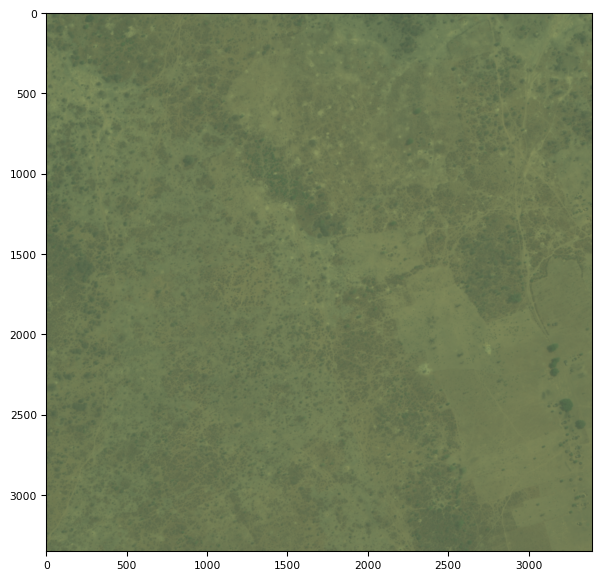

In [0]:
tiff.imshow(img)

(<Figure size 988.8x604.8 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x7ff6acb0e8d0>)

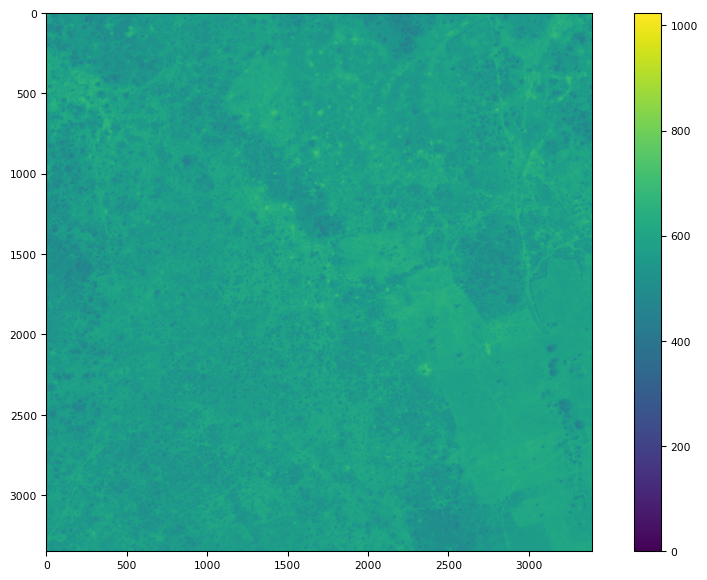

In [0]:
tiff.imshow(img_P)

(<Figure size 988.8x604.8 with 3 Axes>,
 <matplotlib.image.AxesImage at 0x7ff6acab2f60>)

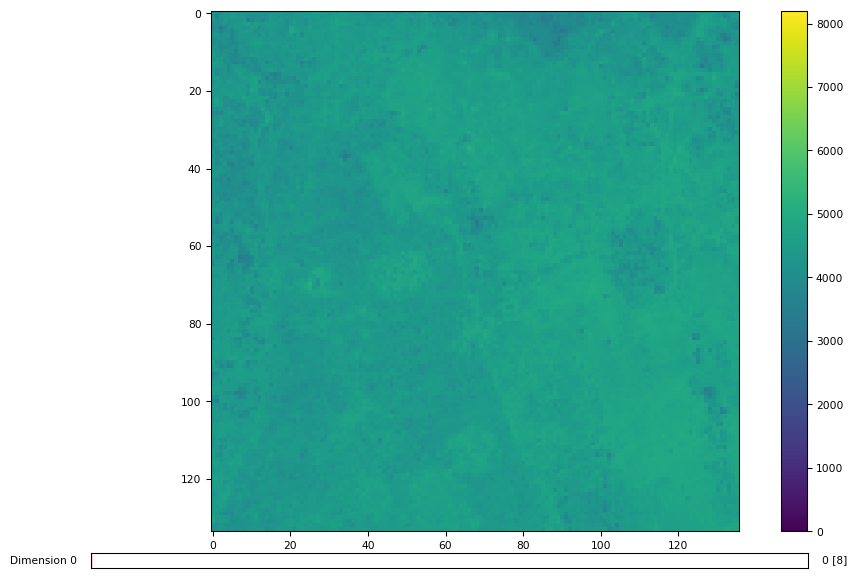

In [0]:
tiff.imshow(img_A)

(<Figure size 988.8x604.8 with 3 Axes>,
 <matplotlib.image.AxesImage at 0x7ff6adb2eac8>)

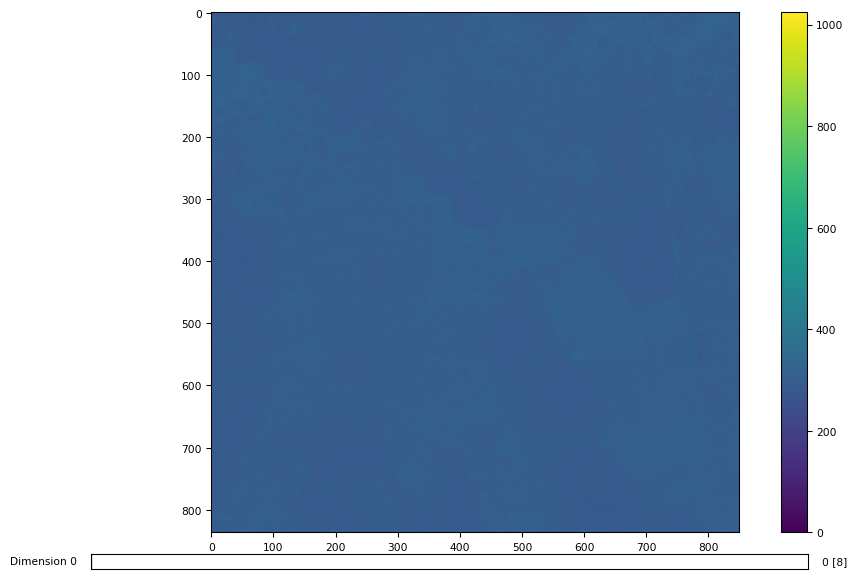

In [0]:
tiff.imshow(img_M)

(<Figure size 988.8x604.8 with 3 Axes>,
 <matplotlib.image.AxesImage at 0x7ff6ace9d278>)

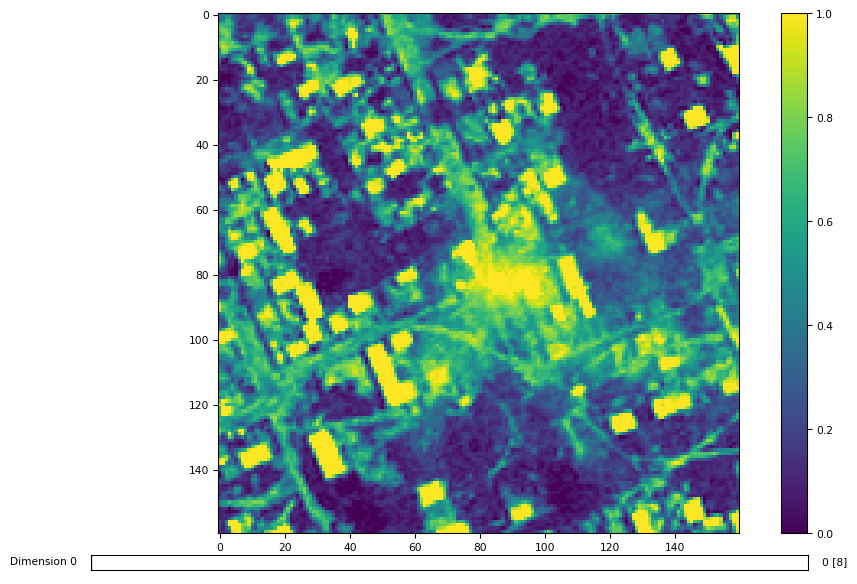

In [0]:
tiff.imshow(ds[126][0])

/usr/local/lib/python3.6/dist-packages/tifffile/tifffile.py:12426: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ) for axis in range(dims)


(<Figure size 988.8x604.8 with 3 Axes>,
 <matplotlib.image.AxesImage at 0x7ff6ab048e10>)

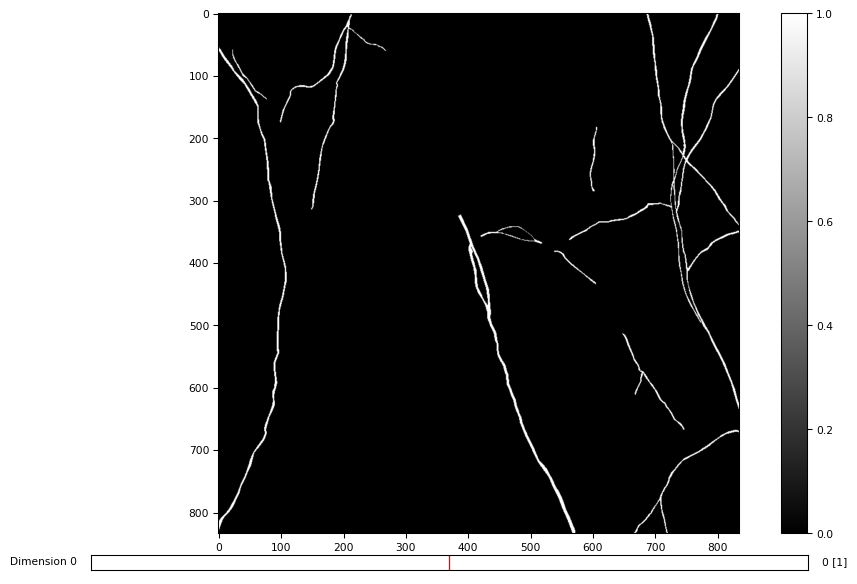

In [0]:
tiff.imshow(y[:,:,3] > 0)